4/4 [==============================] - 1s 20ms/step
======Co-IMF0 Predicting Finished======
          r2      rmse       mae      mape
0  0.939303  0.017272  0.013591  0.026389
Running time: 107.557s
4/4 [==============================] - 1s 17ms/step
======Co-IMF1 Predicting Finished======
          r2      rmse       mae      mape
0  0.948441  0.010116  0.007522  0.018516
Running time: 117.594s
4/4 [==============================] - 1s 17ms/step
======Co-IMF2 Predicting Finished======
          r2      rmse       mae      mape
0  0.977563  0.006268  0.005997  0.012192
Running time: 118.332s
======sh.000001 Predicting Finished======
          r2       rmse        mae      mape
0  0.975644  30.793454  26.876594  0.008086
Total Running time: 463.494s


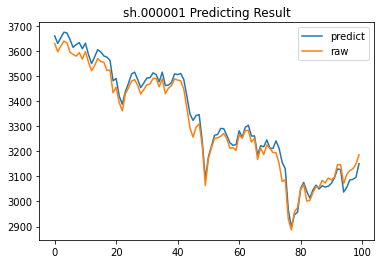

In [108]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# Created on 2022-07-12 13:39
# Author: FATE ZHOU

from __future__ import division, print_function # Loading modules
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD, EEMD, CEEMDAN # CEEMDAN # pip install EMD-signal
from sampen import sampen2 # Sample Entropy
from vmdpy import VMD # VMD
# Sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # R2 MSE MAE MAPE
from sklearn.preprocessing import MinMaxScaler # Normalization
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1.Decomposition function
# ========================================================================
def ceemdan_decompose(series=None, trials=10, num_clusters = 3): # CEEMDAN Decompose
    decom = CEEMDAN()
    decom.trials = trials # Number of the white noise input
    df_ceemdan = pd.DataFrame(decom(series.values).T)
    df_ceemdan.columns = ['imf'+str(i) for i in range(len(df_ceemdan.columns))]
    return df_ceemdan

def sample_entropy(df_ceemdan=None, mm=1, r=0.1): # Sample Entropy Calculate; mm = 1 or 2; r = 0.1 or 0.2 
    np_sampen = []
    for i in range(len(df_ceemdan.columns)):
        sample_entropy = sampen2(list(df_ceemdan['imf'+str(i)].values),mm=mm,r=r,normalize=True)
        np_sampen.append(sample_entropy[1][1])
    df_sampen = pd.DataFrame(np_sampen, index=['imf'+str(i) for i in range(len(df_ceemdan.columns))], columns=[CODE])
    return df_sampen

def kmeans_cluster(df_sampen=None, num_clusters=3): # K-Means Cluster by Sample Entropy
    np_integrate_form = KMeans(n_clusters=num_clusters, random_state=9).fit_predict(df_sampen)
    df_integrate_form = pd.DataFrame(np_integrate_form, index=['imf'+str(i) for i in range(len(df_sampen.index))], columns=['Cluster'])
    return df_integrate_form

def integrate_imfs(df_integrate_form=None, df_ceemdan=None): # Integrate IMFs and Residue to be 3 Co-IMFs
    df_tmp = pd.DataFrame()
    for i in range(df_integrate_form.values.max()+1):
        df_tmp['imf'+str(i)] = df_ceemdan[df_integrate_form[(df_integrate_form['Cluster']==i)].index].sum(axis=1)
    df_integrate_result = df_tmp.T # Use Sample Entropy sorting the Co-IMFs
    df_integrate_result['sampen'] = sample_entropy(df_tmp).values
    df_integrate_result.sort_values(by=['sampen'], ascending=False, inplace=True)
    df_integrate_result.index = ['co-imf'+str(i) for i in range(df_integrate_form.values.max()+1)]
    df_integrate_result = df_integrate_result.drop('sampen', axis=1, inplace=False)
    return df_integrate_result.T

def vmd_decompose(series=None, alpha=2000, tau=0, K=10, DC=0, init=1, tol=1e-7, draw=True): # VMD Decomposition
    imfs_vmd, imfs_hat, omega = VMD(series, alpha, tau, K, DC, init, tol)  
    df_vmd = pd.DataFrame(imfs_vmd.T)
    df_vmd.columns = ['imf'+str(i) for i in range(K)]
    return df_vmd 

# 2.Forecasting function
# ========================================================================
def GRU_model(trainset_shape):# Build GRU model
    model = Sequential()
    model.add(GRU(128, input_shape=(trainset_shape[1], trainset_shape[2]), activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64,activation='tanh',return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32,activation='tanh',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='tanh'))
    model.compile(loss='mse', optimizer='adam')
    return model
        
def evaluation_model(y_test, y_pred): # Model evaluation function
    y_test,y_pred = np.array(y_test).ravel(),np.array(y_pred).ravel()
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False) # MSE and MAE are different on different scales
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    df_evaluation = pd.DataFrame({'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape}, index = range(1))
    return df_evaluation

def create_train_test_set(data=None, timestep=30, co_imf_predict_for_fitting=None): # Create training set and test set with normalization
    if isinstance(data, pd.DataFrame): # Initialize DataFrame training set and test set
        dataY = data['sum'].values.reshape(-1, 1)
        dataX = data.drop('sum', axis=1, inplace=False)
    else: # Initialize Series
        dataY = data.values.reshape(-1, 1)
        dataX = dataY

    scalarX = MinMaxScaler(feature_range=(0,1)) # Normalize by sklearn
    dataX = scalarX.fit_transform(dataX)
    if co_imf_predict_for_fitting is not None: co_imf_predict_for_fitting = scalarX.transform(co_imf_predict_for_fitting)
    
    scalarY = MinMaxScaler(feature_range=(0,1))
    dataY = scalarY.fit_transform(dataY)
    
    trainX, trainY = [], [] # Create training set and test set
    for i in range(len(dataY)-timestep):
        trainX.append(np.array(dataX[i:(i+timestep)]))
        trainY.append(np.array(dataY[i+timestep]))
        if co_imf_predict_for_fitting is not None: # When fitting, it uses today's forecasting result 
            if i<(len(dataY)-timestep-len(co_imf_predict_for_fitting)): trainX[i] = np.insert(trainX[i], timestep, dataX[i+timestep], 0)
            else: trainX[i] = np.insert(trainX[i], timestep, co_imf_predict_for_fitting[i-(len(dataY)-timestep-len(co_imf_predict_for_fitting))], 0)
    
    return np.array(trainX), np.array(trainY), scalarY

def GRU_predict(data=None, epochs=100, predict_duration=100, fitting=None): # GRU forecasting function
    trainX,trainY,scalarY = create_train_test_set(data, co_imf_predict_for_fitting=fitting) # Get training and test X Y
    x_train,x_test = trainX[:-predict_duration],trainX[-predict_duration:] # Split training and test set
    y_train,y_test = trainY[:-predict_duration],trainY[-predict_duration:]
    train_X = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2])) # Convert to tensor 
    test_X = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2])) # Convert to tensor 

    model = GRU_model(train_X.shape) # Build the model # Use model.summary() to show the model structure
    patience = epochs//10 
    EarlyStop = EarlyStopping(monitor='val_loss', patience=5*patience, verbose=0, mode='auto') # Early stop at small learning rate
    Reduce = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=0, mode='auto') # Adaptive learning rate
    history = model.fit(train_X, y_train, epochs=epochs, batch_size=16, validation_split=0.1, verbose=0, shuffle=True, callbacks=[EarlyStop,Reduce]) # Train the model
    
    y_test_predict = model.predict(test_X) # Predict
    df_gru_evaluation = evaluation_model(y_test, y_test_predict) # Evaluate model
    y_test_predict = y_test_predict.ravel().reshape(-1,1) 
    y_test_predict_result = scalarY.inverse_transform(y_test_predict) # De-normalize 
    y_test_raw = scalarY.inverse_transform(y_test)    
    df_predict_raw = pd.DataFrame({'raw': y_test_raw.ravel(), 'predict': y_test_predict_result.ravel()}, index=range(len(y_test_raw))) # Output
    df_train_loss= pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, index=range(len(history.history['val_loss'])))
    return df_predict_raw, df_gru_evaluation, df_train_loss

# 3.Main function
# ========================================================================
if __name__ == '__main__':
    start = time.time()
    CODE, PATH = 'sh.000001', 'D:\\Stock-LSTM\\' # code such as 'sh.000001'

    # 1.Load raw data
    df_raw_data = pd.read_csv(PATH+CODE+'.csv', header=0, parse_dates=['date'], date_parser=lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
    series_close = pd.Series(df_raw_data['close'].values,index = df_raw_data['date'])

    # 2.CEEMDAN decompose
    df_ceemdan = ceemdan_decompose(series_close) 
    # df_ceemdan.plot(title='CEEMDAN Decomposition', subplots=True)

    # 3.Sample Entropy Calculate
    df_sampen = sample_entropy(df_ceemdan) 
    # df_sampen.plot(title='Sample Entropy')

    # 4.K-Means Cluster by Sample Entropy
    df_integrate_form = kmeans_cluster(df_sampen) 
    # print(df_integrate_form)

    # 5.Integrate IMFs and Residue to be 3 Co-IMFs
    df_integrate_result = integrate_imfs(df_integrate_form, df_ceemdan)
    # df_integrate_result.plot(title='Integrated IMFs (Co-IMFs) of CEEMDAN', subplots=True)

    # 6.Secondary Decompose the high-frequency Co-IMF0 by VMD
    df_vmd_co_imf0 = vmd_decompose(df_integrate_result['co-imf0']) # vmd decomposition (The number of dataset must be even)
    # df_vmd_co_imf0.plot(title='VMD Decomposition of Co-IMF0', subplots=True)

    # 7.Predict Co-IMF0 by matrix-input GRU
    time0 = time.time()
    df_vmd_co_imf0['sum'] = df_integrate_result['co-imf0']
    co_imf0_predict_raw, co_imf0_gru_evaluation, co_imf0_train_loss = GRU_predict(df_vmd_co_imf0)
    print('======Co-IMF0 Predicting Finished======\n', co_imf0_gru_evaluation)
    time1 = time.time()
    print('Running time: %.3fs'%(time1-time0))
    # co_imf0_predict_raw.plot(title='Co-IMF0 Predicting Result')
    # co_imf0_train_loss.plot(title='Co-IMF0 Training Loss')

    # 8.Predict Co-IMF1 and Co-IMF2 by vector-input GRU
    co_imf1_predict_raw, co_imf1_gru_evaluation, co_imf1_train_loss = GRU_predict(df_integrate_result['co-imf1'])
    print('======Co-IMF1 Predicting Finished======\n', co_imf1_gru_evaluation)
    time2 = time.time()
    print('Running time: %.3fs'%(time2-time1))
    # co_imf1_predict_raw.plot(title='Co-IMF1 Predicting Result')
    # co_imf1_train_loss.plot(title='Co-IMF1 Training Loss')

    co_imf2_predict_raw, co_imf2_gru_evaluation, co_imf2_train_loss = GRU_predict(df_integrate_result['co-imf2'])
    print('======Co-IMF2 Predicting Finished======\n', co_imf2_gru_evaluation)
    time3 = time.time()
    print('Running time: %.3fs'%(time3-time2))
    # co_imf2_predict_raw.plot(title='Co-IMF2 Predicting Result')
    # co_imf2_train_loss.plot(title='Co-IMF2 Training Loss')

    # 9. Add 3 result to get the final forecasting result (instead fitting method )
    duration = 100
    series_add_predict_result = co_imf0_predict_raw['predict']+co_imf1_predict_raw['predict']+co_imf2_predict_raw['predict']
    df_add_predict_raw = pd.DataFrame({'predict': series_add_predict_result.values, 'raw': series_close[-duration:].values}, index=range(duration))
    df_add_evaluation = evaluation_model(series_close[-duration:],series_add_predict_result)
    print('======'+CODE+' Predicting Finished======\n', df_add_evaluation)
    end = time.time()
    print('Total Running time: %.3fs'%(end-start))
    df_add_predict_raw.plot(title=CODE+' Predicting Result')
    # pd.DataFrame.to_csv(df_add_predict_raw, PATH+CODE+'_predict_output.csv')

    # 10.Fit 3 result to get the final forecasting result (instead adding method )
    """
    df_co_imf_predict_raw =  pd.DataFrame({'co-imf0': co_imf0_predict_raw['predict'], 'co-imf1': co_imf1_predict_raw['predict'], 'co-imf2': co_imf2_predict_raw['predict']}, index=range(len(co_imf0_predict_raw)))
    df_fitting_set = df_integrate_result
    df_fitting_set['sum'] = series_close.values
    df_predict_raw, df_gru_evaluation, df_train_loss = GRU_predict(df_fitting_set, fitting=df_co_imf_predict_raw)
    print('======'+CODE+' Predicting Finished======\n', df_gru_evaluation)
    end = time.time()
    print('Running time: %.3fs'%(end-time3))
    print('Total Running time: %.3fs'%(end-start))
    df_predict_raw.plot(title=CODE+' Predicting Result')
    df_train_loss.plot(title=CODE+' Training Loss')
    # pd.DataFrame.to_csv(df_predict_raw, PATH+CODE+'_predict_output.csv')
    """